In [ ]:
#!pip install ydata-synthetic
#https://colab.research.google.com/github/ydataai/ydata-synthetic/blob/master/examples/timeseries/TimeGAN_Synthetic_stock_data.ipynb#scrollTo=tw63DsLXhfYo

  Obtaining dependency information for ydata-synthetic from https://files.pythonhosted.org/packages/b1/32/7d7b040877236f47b478a916f64e3e44a2829bae6b1523333fc0d4877169/ydata_synthetic-1.4.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for requests<2.31,>=2.28 from https://files.pythonhosted.org/packages/96/80/034ffeca15c0f4e01b7b9c6ad0fb704b44e190cde4e757edbd60be404c41/requests-2.30.0-py3-none-any.whl.metadata
  Obtaining dependency information for tensorflow==2.15.* from https://files.pythonhosted.org/packages/1c/b7/604ed5e5507e3dd34b14295d5e4a762d47cc2e8cf29a23b4c20575461445/tensorflow-2.15.1-cp310-cp310-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-probability[tf] from https://files.pythonhosted.org/packages/fe/b6/e116761ceeb880b7ad4c6a7e1203538754dd7dda42538f08d6daaf8dfa4d/tensorflow_probability-0.25.0-py2.py3-none-any.whl.metadata
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Ge

ERROR: Could not install packages due to an OSError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\Josiah Lee\\AppData\\Local\\Programs\\Python\\Python310\\Lib\\site-packages\\tensorflow\\python\\_pywrap_tensorflow_internal.pyd'
Consider using the `--user` option or check the permissions.


[notice] A new release of pip is available: 23.2.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Obtaining dependency information for ydata-synthetic from https://files.pythonhosted.org/packages/b1/32/7d7b040877236f47b478a916f64e3e44a2829bae6b1523333fc0d4877169/ydata_synthetic-1.4.0-py2.py3-none-any.whl.metadata
  Using cached ydata_synthetic-1.4.0-py2.py3-none-any.whl.metadata (10 kB)
  Obtaining dependency information for tensorflow==2.15.* from https://files.pythonhosted.org/packages/1c/b7/604ed5e5507e3dd34b14295d5e4a762d47cc2e8cf29a23b4c20575461445/tensorflow-2.15.1-cp310-cp310-win_amd64.whl.metadata
  Using cached tensorflow-2.15.1-cp310-cp310-win_amd64.whl.metadata (3.4 kB)
  Obtaining dependency information for pmlb==1.0.* from https://files.pythonhosted.org/packages/db/e3/6e6d1cb10b6736ceb1693f6ad8f8f979a3c8a101e9b20c4fd1a1613d3a76/pmlb-1.0.1.post3-py3-none-any.whl.metadata
  Using cached pmlb-1.0.1.post3-py3-none-any.whl.metadata (1.7 kB)
  Obtaining dependency information for tensorflow-intel==2.15.1 from https://files.pythonhosted.org/packages/02/13/681487f4f5241d8213


[notice] A new release of pip is available: 23.2.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ydata_synthetic.synthesizers import ModelParameters, TrainParameters
from ydata_synthetic.preprocessing.timeseries import processed_stock
from ydata_synthetic.synthesizers.timeseries import TimeSeriesSynthesizer

In [10]:
# Specific to TimeGANs
seq_len = 24
n_seq = 1
hidden_dim = 24
gamma = 1

noise_dim = 32
dim = 128
batch_size = 128

log_step = 100
learning_rate = 5e-4
# For quick prototyping
# epochs=50000
epochs = 10

gan_args = ModelParameters(
    batch_size=batch_size, lr=learning_rate, noise_dim=noise_dim, layers_dim=dim
)

train_args = TrainParameters(
    epochs=epochs, sequence_length=seq_len, number_sequences=n_seq
)

In [11]:
wti_df = pd.read_csv('../data/wti_prices.csv', index_col=0, parse_dates=['Date'])
cols = list(wti_df.columns)
print(wti_df.shape)
print(cols)

(481, 1)
['WTI_price']


In [12]:
if path.exists("synthesizer_wti.pkl"):
    synth = TimeSeriesSynthesizer.load("synthesizer_wti.pkl")
else:
    synth = TimeSeriesSynthesizer(modelname="timegan", model_parameters=gan_args)
    synth.fit(wti_df, train_args, num_cols=cols)
    synth.save("synthesizer_wti.pkl")

A DataProcessor is not available for the TimeGAN.


Joint networks training: 100%|██████████| 10/10 [01:06<00:00,  6.60s/it]
c:\Users\Josiah Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:486: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [13]:
stock_data_blocks = processed_stock(path='../data/wti_prices.csv', seq_len=seq_len)
synth_data = np.asarray(synth.sample(len(stock_data_blocks)))
print(synth_data.shape)

(457, 24, 1)


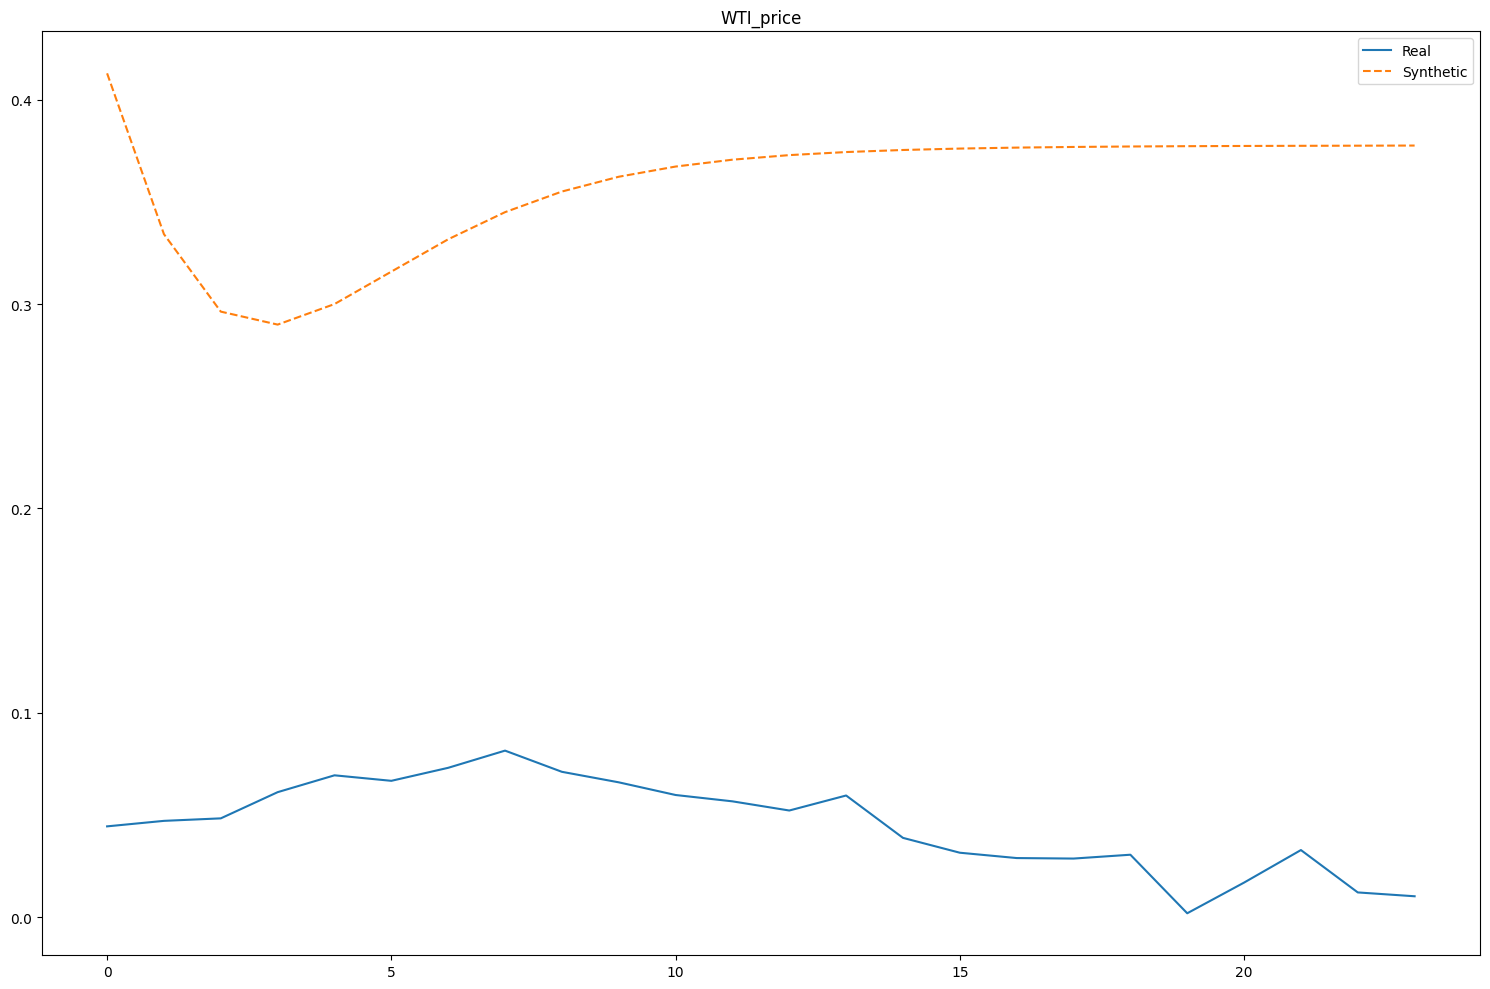

In [15]:
#Plotting some generated samples. Both Synthetic and Original data are still standartized with values between [0,1]
fig, axes = plt.subplots(figsize=(15, 10))

time = list(range(1,25))
obs = np.random.randint(len(stock_data_blocks))

for j, col in enumerate(cols):
    df = pd.DataFrame({'Real': stock_data_blocks[obs][:, j],
                   'Synthetic': synth_data[obs][:, j]})
    df.plot(ax=axes,
            title = col,
            secondary_y='Synthetic data', style=['-', '--'])
fig.tight_layout()